# Notebook content overview

This notebook presents code that allows to explore the pre synaptic conenctome of a neuron based on the profile of the selectivity of the currents of the its presynaptic neurons to different angles. It also allows to extract an updated connectome of only selective cells with their preferred orientations and accompanying spike trace responses to Monet2 stimuli

### Data Read In

This notebook utilises the data **functional_connectome_stcorr.csv** from the st_correlation_analysis.ipynb notebook, the **clean_functional_ccmax_ost.pkl** data from the *neuron_activity_extraction.pkl* notebook and the **orientation_fits.csv** data from the *orientation_extraction.ipynb* notebook.

### Extracting layers of functional cells

Utilised the standard_transform package to extract the layers that each nenuron belong to.

    NOTE: This information has been saved locally as a file named **clean_functional_layers.pkl**

### Generate the set of selective cells

Subsetted the functional cells to only leave those that are selective in some way (removed fringe cases and non selective cells). In addition I have discretized the preferred orientation, finding the one that is closes to the 16 orientations shown in the Monet2 trials

    NOTE: This set of selective cells and all new information has been saved locally with teh label **selective_cells.pkl**

### Connectivity profile of pre-synaptic neurons of a sample of neurons

In this section I have visualised how the number of connnectiosnn that are selective, functionally matched and teh number of connectionsn overall varies in a sample of 100 neurons.

### Single neuron test of subset L2/3 and angles

In this section the currents annd discretized maximums of the presynaptic, selective neurons of a specified post synaptic neuron from layer 2/3 of V1 are extracted.

###  Iterate through cells to extract current data

In this section an iterative routine is utilised to extract teh infnormation detailed in teh previous section for ALL cells in layer 2/3 of V1

    NOTE. This information is saved locally for each cell individually in files labelled with the schema currents_{postcell_id}.pkl, at first and then collated in a single file labelled **total_currents.pkl**




# Imports

In [1]:
import random
#import datajoint as dj
#from phase3 import nda, func, utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
from PIL import Image
from matplotlib import cm
from collections import defaultdict
from scipy.optimize import curve_fit
import time
import gc
from PIL import Image
import warnings
import pickle
#!pip3 install scikit-learn
import sklearn as sk
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from scipy.stats import sem
from scipy.stats import mannwhitneyu, wilcoxon
import os
from caveclient import CAVEclient
import nglui
#!pip install standard-transform
from standard_transform import minnie_transform_vx

In [22]:
client = CAVEclient()
auth = client.auth
auth.get_new_token()

New Tokens need to be acquired by hand. Please follow the following steps:
                1) Go to: https://global.daf-apis.com/auth/api/v1/create_token to create a new token.
                2) Log in with your Google credentials and copy the token shown afterward.
                3a) Save it to your computer with: client.auth.save_token(token="PASTE_YOUR_TOKEN_HERE")
                or
                3b) Set it for the current session only with client.auth.token = "PASTE_YOUR_TOKEN_HERE"
                Note: If you need to save or load multiple tokens, please read the documentation for details.
                Warning! Creating a new token by finishing step 2 will invalidate the previous token!


In [25]:
new_token = '451603479604d9d2fddf6d8a04322218' #This is the text you see after you visit the website.
auth.save_token(token=new_token)

# Data Read In

In [44]:
#Connect to CaveClient
client = CAVEclient('minnie65_public_v343')

In [2]:
#Read in the data
connectome = pd.read_csv('../Data/functional_connectome_stcorr.csv')
func_data = pd.read_pickle('../Data/funcneurons_features_versions/clean_functional_ccmax_ost.pkl')
fits = pd.read_csv('../Data/orientation_fits.csv')
fits = fits.rename(columns = {'cell_id':'unit_id'})

# Extracting layers of functional cells

In [ ]:
#Define transform and import CAVE data
tform_vx = minnie_transform_vx()
func_data_cave=client.materialize.query_table('functional_coreg')

In [ ]:
#Reassinge the pt_position to be a column with position arrays (saving the file had mutated it to strings)
func_data_cave = func_data_cave.loc[:, ['pt_root_id', 'pt_position']]
func_data_cave =func_data_cave.drop_duplicates(subset = 'pt_root_id').iloc[1:, :]
func_complete = func_data.merge(func_data_cave, how = 'left', left_on='pt_root_id', right_on='pt_root_id', copy = False)

In [ ]:
#Replace NaNs with the right value
func_complete = func_complete.drop('pt_position_x', axis = 1)
func_complete = func_complete.rename(columns = {'pt_position_y': 'pt_position'})
pos = np.array([274864,94064,22046])
func_complete.at[0,'pt_position'] = pos

Layer membership was classified by depth of imaged soma respect to the dura in the structural two-photon stack: L1: 0 − 98 μm; L2/3: 98 − 283 μm; L4: 283 − 371 μm; L5: 371 − 574 μm; L6: 574 − 713 μm 8Dinge et al. 2023)

In [ ]:
#Apply the transform and save it in a new column
func_complete['pial_distances'] = tform_vx.apply(func_complete['pt_position'])

#Use the y axis value to assign the corresponding layer as per Ding et al. 2023
layers = []
for i in func_complete['pial_distances'].iloc[:]:
    if 0<i[1]<=98:
        layers.append('L1')
    elif 98<i[1]<=283:
        layers.append('L2/3')
    elif 283<i[1]<=371:
        layers.append('L4')
    elif 371<i[1]<=574:
        layers.append('L5')
    elif 574<i[1]<=713:
        layers.append('L6')

func_complete['cortex_layer'] = layers    

In [ ]:
#Save the data
#func_complete.to_pickle('clean_functional_layers.pkl')

In [33]:
func_complete = pd.read_pickle('../Data/clean_functional_layers.pkl')

# Generate the set of selective cells

In [34]:
##### Merge orientation and functional datasets
merged_fun = func_complete.merge(fits, on = ['scan_idx', 'session', 'unit_id'], how = 'right')

#Select all cells that are selective
good = merged_fun[merged_fun['pvalue']<0.05]

#Select all cells that are significant according to both models
grouped_res = good.groupby(['pt_root_id']).count().reset_index()
double_sig = grouped_res[grouped_res['pvalue']>1]['pt_root_id'].values

#Select only the double model of those with 'fringe case'
double_fringe = good[(good['pt_root_id'].isin(double_sig)) & (good['r_squared_diff']>0.8) & (good['model_type'] == 'double')]

#Select only single model in neurons where both models significant and not 'fringe'
single_good = good[(good['pt_root_id'].isin(double_sig)) & (good['r_squared_diff']<0.8) & (good['model_type'] == 'single')]

#Select all remaining neurons with significant models
remaining_good = good[~good['pt_root_id'].isin(double_sig)]

almost_good = pd.concat([double_fringe,single_good,remaining_good])

#select all neurons from fringe case 2
fringe2 = almost_good[(almost_good['r_squared_diff']<-0.5)&(almost_good['model_type'] == 'double') & (almost_good['pvalue'] <0.05)]['pt_root_id']

all_good = almost_good[~almost_good['pt_root_id'].isin(fringe2)]
all_good.head(2)

,id,valid,pt_supervoxel_id,pt_root_id,session,scan_idx,unit_id,stack_x,stack_y,stack_z,...,pt_position,pial_distances,cortex_layer,pvalue,model_type,r_squared_diff,mean_r_sqrd,A,phi,k
41,1497,t,87548682551482032,864691136084036460,7,3,2041,968.15,947.27,213.87,...,"[165840, 135296, 18902]","[613.6684214429918, 200.26923279088533, 756.08...",L2/3,0.000044,double,0.839911,0.885874,3.208112,3.078375,1.005907
343,3748,t,96983798457163459,864691135968943205,7,3,6935,1118.37,685.57,421.25,...,"[234432, 177728, 22099]","[872.1995984639533, 393.2641133347905, 883.960...",L5,0.000097,double,0.923305,0.937401,2.883878,3.218863,1.671461


### Extract discretised maximum for each cell

(i.e. discretized maximum shown in stimuli closest to estimated maximum)

In [ ]:
#Generate array with the directiosn shown in the stimuli
trial_key = {'session': 4, 'scan_idx': 7}
trial_info = nda.Trial & trial_key
tid = (trial_info * nda.Monet2).fetch('trial_idx')[0]
u_key = {'session': 4, 'scan_idx':7, 'trial_idx':tid}
u_info = nda.Trial & u_key
dirs = (u_info*nda.Monet2).fetch1('directions')[0]
dirs_rad = dirs*(np.pi/180)

In [66]:
#if DataJoint unavailable and wish to run visualisations in the 
# 'Connectivity profile of pre-synaptic neurons of a sample of neurons' section
cur = pd.read_pickle('../Data/total_currents.pkl')
dirs = np.array(list(set(cur['disc_max_post'])))
dirs_rad = dirs*(np.pi/180)

In [67]:
#Add column with value from the shown directions that is closest to the maximum
closemax = []
for max_phi in all_good['phi'].iloc[:]:
    diff_idx= np.argmin(np.abs((dirs_rad-max_phi)))
    closemax.append(dirs_rad[diff_idx])
all_good['closemax'] = closemax
    

/var/folders/h3/qq6d8krs4yb4t52bbzsx7kpw0000gn/T/ipykernel_20245/1460390797.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_good['closemax'] = closemax


In [ ]:
#Save it
#all_good.to_pickle('selective_cells.pkl')

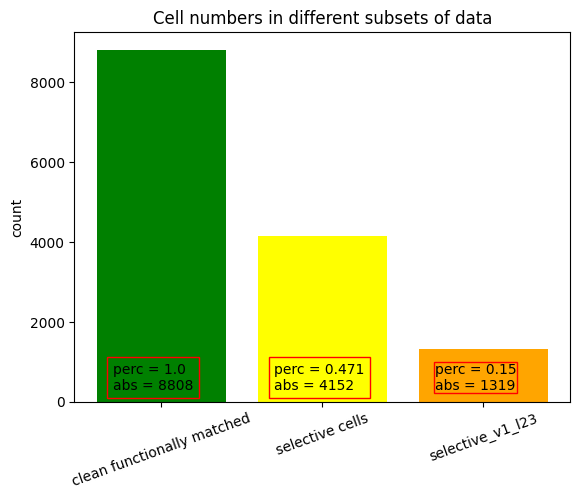

In [106]:
#Distribution across the datasets
sel = pd.read_pickle('../Data/selective_cells.pkl')
good_post = sel[(sel['brain_area'] == 'V1') &(sel['cortex_layer'] == 'L2/3')]
funcm = len(set(connectome['post_pt_root_id']))
selec = len(set(sel['pt_root_id']))
selv1l23 = len(set(good_post['pt_root_id']))
labels = ['clean functionally matched', 'selective cells', 'selective_v1_l23']
values = [funcm, selec, selv1l23]
color = ['green', 'yellow', 'orange']

plt.bar(labels, values, color = color)
plt.title('Cell numbers in different subsets of data')
plt.text(-0.3,300, f'perc = {funcm/funcm}\nabs = {funcm}', bbox = dict(facecolor='none', edgecolor='red'))
plt.text(0.7,300, f'perc = {round(selec/funcm, 3)}\nabs = {selec}', bbox = dict(facecolor='none', edgecolor='red'))
plt.text(1.7,300, f'perc = {round(selv1l23/funcm,3)}\nabs = {selv1l23}', bbox = dict(facecolor='none', edgecolor='red', pad = 0.5))
plt.ylabel('count')
plt.xticks(rotation = 20)
plt.show()

# Utility functions

In [ ]:
def orientation_extractor(unit_key, fpd):
    ''' This function extracts a dataframe for the specified neuron with the mean activity across stimuli repeats
    at each of the predefined 16 orientations shown in the Monet2 stimulus
    
    Parameters:
    unit_key: datajoint style dictionary specifying the session, scan_idx and unit_idx of the selected neuron
    fpd: number of frames per direction (some sessions+scan_idx pairs had different numbers
    
    Returns:
    dataframe with three columns:
    orinetations: dergee of orientation of teh stimuli
    radian: conetnts of orientation column but in radians
    mean_activity: mean activity of the neuron across repeats of the stimulus with the same orientation
    '''
    
    #Select the movie trials in the appropiate session and scan
    trial_key = {'session': unit_key['session'], 'scan_idx': unit_key['scan_idx']}
    trial_info = nda.Trial & trial_key
    
    #Extract the direction variables for the Monet2 stimuli in these trials
    dirs = (trial_info* nda.Monet2).fetch('directions')
    spike_trace = (nda.Activity() & unit_key).fetch1('trace')

    #Extract start and end frames
    s = (trial_info * nda.Monet2).fetch('start_idx')
    e = (trial_info * nda.Monet2).fetch('end_idx')
    
    #Loop thorugh them and calculate average activity and corresponding direction
    directions=[]
    m_act = []
    d = 0

    #loop though each monet trial
    for seg in range(len(s)):
        st = s[seg]
        en = e[seg]
        c = 0

        #extract the relevant spike trace segment
        sp_red = spike_trace[st:en+1]
        #loop though each six frames with same orientation
        if fpd>6: #change number of frame that have the same direction since session 9 had a higher frame rate of 8
            for i in range(0, sp_red.shape[0], fpd):
                if c < 16:
                    directions.append(dirs[d][0][c]) #d: monet trial number, 0: selects array, c: orientation index
                    m_act.append(np.mean(sp_red[i:i+fpd]))
                else:
                    continue
                    #directions.append(dirs[d][0][c])
                    #m_act.append(np.mean(sp_red[i:]))
                c+=1
        else:    
            for i in range(0, sp_red.shape[0], 6):
                if c < 16:
                    directions.append(dirs[d][0][c]) #d: monet trial number, 0: selects array, c: orientation index
                    m_act.append(np.mean(sp_red[i:i+6]))
                else:
                    directions.append(dirs[d][0][c])
                    m_act.append(np.mean(sp_red[i:]))
                c+=1
        d+=1
    #Save them in a data frame  
    df = pd.DataFrame({'orientation':directions, 'mean_activity':m_act})
    
    #Turn orientation in to radians
    df['radians'] = df['orientation']*(np.pi/180)
    
    return df

# Connectivity profile of pre-synaptic neurons of a sample of neurons

In [45]:
#Visualise disrtributions of n of connections, n of connections from functionally matched neurons
#and n of connectiosn from functionally matched neurons that are selective in a random sample of 100 neurons

np.random.seed(4)

sample = np.random.choice(func_data['pt_root_id'], 100)
#Initialise containers
n_connections = []
n_funcmatch = []
n_selective = []
 

for root_id in tqdm(sample):
    #extract nn of presynaptic connections
    syn = len(set(client.materialize.synapse_query(post_ids=root_id)['pre_pt_root_id']))
    
    #extract functionally matched connections
    pre_set = set(connectome[connectome['post_pt_root_id'] == root_id]['pre_pt_root_id'])
    
    #extract functionally matched tuned connections
    good_and_selective = set(all_good['pt_root_id']).intersection(pre_set)
    
    #save them
    n_connections.append(syn)
    n_funcmatch.append(len(pre_set))
    n_selective.append(len(good_and_selective))

#generate a dictionary with cell id and number of selective connections, then sort it
cdict = {v:k for k, v in zip(sample, n_selective)}
st = sorted(cdict, reverse=True)
cdict[st[0]]

  0%|          | 0/100 [00:00<?, ?it/s]

864691135491623263

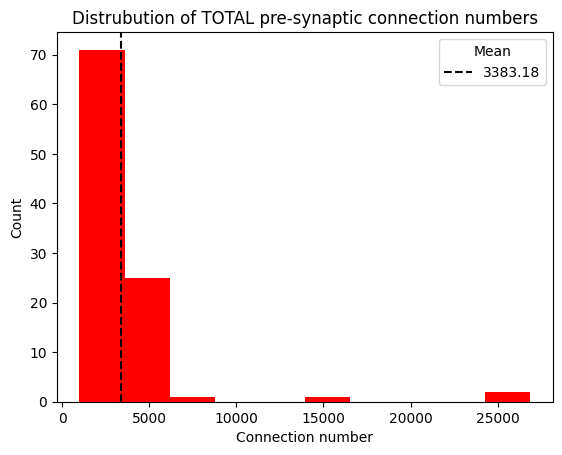

In [46]:
#Distribution of overall connection numbers
plt.hist(n_connections, color = 'red')

#adding the mean
mean = np.mean(n_connections)
plt.axvline(mean, color = 'black', linestyle = '--', label = round(mean, 2))
plt.ylabel('Count')
plt.xlabel('Connection number')
plt.title('Distrubution of TOTAL pre-synaptic connection numbers')
plt.legend(title = 'Mean')
plt.show()

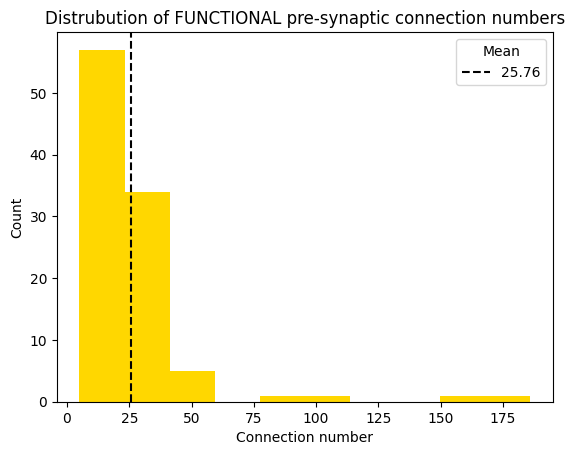

In [47]:
#Distribution of connection numbers from functionally matched cells
plt.hist(n_funcmatch, color = 'gold')

#adding the mean
mean = np.mean(n_funcmatch)
plt.axvline(mean, color = 'black', linestyle = '--', label = round(mean, 2))
plt.ylabel('Count')
plt.xlabel('Connection number')
plt.title('Distrubution of FUNCTIONAL pre-synaptic connection numbers')
plt.legend(title = 'Mean')
plt.show()

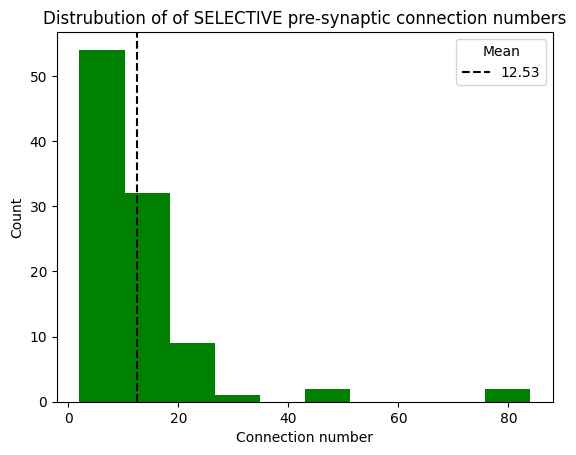

In [48]:
#Distribution of connection numbers from selective pre synaptic neurons
plt.hist(n_selective, color = 'green')

#adding the mean
mean = np.mean(n_selective)
plt.axvline(mean, color = 'black', linestyle = '--', label = round(mean, 2))
plt.ylabel('Count')
plt.xlabel('Connection number')
plt.title('Distrubution of of SELECTIVE pre-synaptic connection numbers')
plt.legend(title = 'Mean')
plt.show()

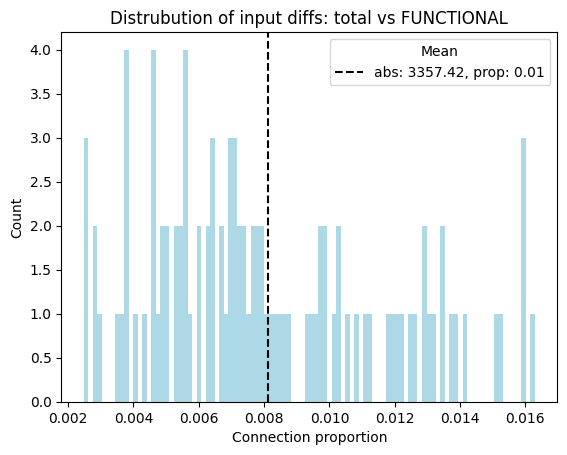

In [49]:
#Distrubution of proportion of FUNCTIONALLY matched inputs out of total innputs to a neuron

#Calculate the proportion of functionally matched inputs out of total input for each neuron in sample
diffs = np.array(n_funcmatch)/np.array(n_connections)
#Mean proportion
mean = np.mean(np.array(n_connections)-np.array(n_funcmatch))

#Plot it
plt.hist(diffs, bins = 100, color = 'lightblue')
plt.axvline(meanp, color = 'black', linestyle = '--', label = f'abs: {round(mean, 2)}, prop: {round(meanp, 2)}')
plt.ylabel('Count')
plt.xlabel('Connection proportion')
plt.title('Distrubution of input diffs: total vs FUNCTIONAL')
plt.legend(title = 'Mean')
plt.show()

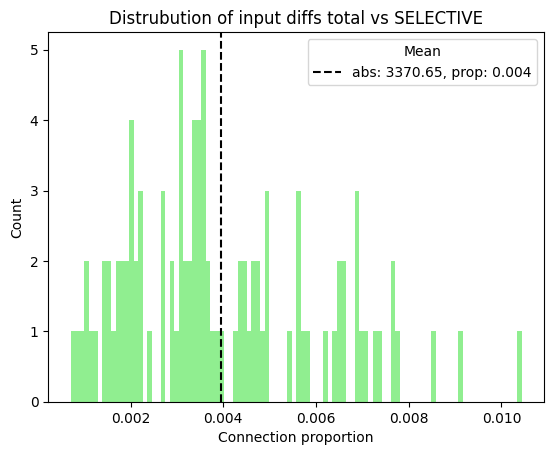

In [50]:
# Distrubution of proportion of SELECTIVE inputs out of total innputs to a neuron

#Calculate the proportion of selective inputs out of total input for each neuron in sample
diffs = np.array(n_selective)/np.array(n_connections)
#Mean proportion
mean = np.mean(np.array(n_connections)-np.array(n_selective))

#Plot it
plt.hist(diffs, bins = 100, color = 'lightgreen')
plt.axvline(meanp, color = 'black', linestyle = '--', label = f'prop: {round(meanp, 4)}')
plt.ylabel('Count')
plt.xlabel('Connection proportion')
plt.title('Distrubution of proportion of SELECTIVE inputs out of total innputs to a neuron')
plt.legend(title = 'Mean')
plt.show()

# Single neuron test of subset L2/3 and angles
In these test we subest the plots of the currents by the layer the neuron belongs to and by the discretised preferred maximum orientation they display.

NOTE: the preferred orientation of neurons has been 'discretised', meaning that we set tehir preferred orientation as the closest angle to the 16 shown in the Monet2 trials that their preferred orientation estimated in *orienttation_extraction.ipynb* comes closest to.

New fringe case discovered:
In some cells the orientation (double peak model) fits very poorly, placing a maximum in an area where there should not be one and thus is discretized wrongly, causing the summation for that discretized angle to show a peak in the worng point(example in presynaptic cells of post synaptic cell with id: 864691136334171571 but now fixed by 'fringe2' variable in 'Generate set of selective cells' section)

In [327]:
# Select all the POST_synaptic neurons that are from V1 and layer 2/3
good_post = all_good[(all_good['brain_area'] == 'V1') &(all_good['cortex_layer'] == 'L2/3')]

# Select all the PRE_synaptic neurons that are from V1 and layers 2/3/4
good_v1 = all_good[all_good['brain_area'] == 'V1']
good_layers = good_v1[(good_v1['cortex_layer'] == 'L2/3') | (good_v1['cortex_layer'] == 'L4')]

In [94]:
good_post.shape

NameError: name 'good_post' is not defined

In [ ]:
#Generate a dictionary to select those neurons that have a lot of presynpatic connections
l = []
#iterate trhough good post synpatic cells
for i in tqdm(good_post['pt_root_id'].iloc[:]):
    #select all its connections
    pre_set = set(connectome[connectome['post_pt_root_id'] == i]['pre_pt_root_id'])
    #select only the ones in teh layers we want
    good_and_selective = set(good_layers['pt_root_id']).intersection(pre_set)
    #append how many there are
    l.append(len(good_and_selective))
    
#generate a dictionary and sort it  
lengths_andids = {k:v for k, v in zip(good_post['pt_root_id'].iloc[:], l)}
sort_lids = sorted(lengths_andids.items(), key=lambda x:x[1], reverse = True)


In [ ]:
#Visualise the first few ones
sort_lids[:10]

In [ ]:
#Select the cell you wish to examine
post_root_id = 864691136334171571

#Find all the pre-synpatic neuron that connect into it, are selective and are from V1, layers 2/3/4
pre_set = set(connectome[connectome['post_pt_root_id'] == post_root_id]['pre_pt_root_id'])
good_and_selective = set(good_layers['pt_root_id']).intersection(pre_set)

In [ ]:
phi_diffs = []
connection_strength = []
actJ = defaultdict(lambda: defaultdict(list))
act_no_w = defaultdict(lambda: defaultdict(list))

for neuron_id in tqdm(good_and_selective):
    #Find the pre synaptic preferred orientation
    pre_max = all_good[all_good['pt_root_id'] == neuron_id]['phi'].iloc[0]
    
    #Find the pre synaptic DISCRETIZED preferred orientation
    closepre_max = all_good[all_good['pt_root_id'] == neuron_id]['closemax'].iloc[0]
    
    #presynaptic layer
    pre_layer = all_good[all_good['pt_root_id'] == neuron_id]['cortex_layer'].iloc[0]
            
    #Find difference in orientation and save it
    #orientation_diff = np.abs(post_max-pre_max)
    #phi_diffs.append(orientation_diff)
            
    #find the connection strength (size of synapse as proxy)
    size = connectome[(connectome['pre_pt_root_id'] == neuron_id) & (connectome['post_pt_root_id'] == post_root_id)]['size'].values
    syn_strength = np.sum(size)
    connection_strength.append(syn_strength)
            
    #Generate unit key for the pre synpatic neuron
    ssu= func_data[func_data['pt_root_id'] == neuron_id][['session', 'scan_idx', 'unit_id']].values
    unit_key = {'session': ssu[0][0], 'scan_idx': ssu[0][1], 'unit_id': ssu[0][2]}  
    
    #Extract its activity and corresponding radian values
    if unit_key['session'] !=9:
        df = orientation_extractor(unit_key, 6)
    else:
        df = orientation_extractor(unit_key, 8)
    
    #Group by the radian to get the average neuron activity at that radian value
    gp = df.groupby('radians').mean().reset_index()
    
    #Save the orientations and the presynaptic activity times its connetcion strength
    #radians+= list(gp['radians']) #Subtract by post_max to centre preferred orientation at 0
    actJ[pre_layer][closepre_max].append(list(gp['mean_activity']*syn_strength))
    act_no_w[pre_layer][closepre_max].append(list(gp['mean_activity']))
        


In [ ]:
#Select the layer of origin of the pre-synpatic cells
layer = 'L2/3'

#Visulaise how many pre synpatic cells there are for each of the discretised orientations
for i in actJ[layer].keys():
    print(i, len(actJ[layer][i]))
    
print(f'number of orientations available: {len(actJ[layer].keys())}')

In [ ]:
#Generate a plot to visualise the sum of teh currents of pre-synaptic neurons with teh same preferred
#orientation for the selected post synaptic neuron they have been extracted for
fig, axes = plt.subplots(3, 5, figsize = (30,15))

for ax, rad in zip(axes.ravel(),actJ[layer].keys()) :
    ax.plot(sorted(dirs_rad), np.sum(np.array(actJ[layer][rad]), axis = 0), label = 'summed activity')
    ax.axvline(rad, color = 'red', label= 'disc maximum')
    if rad>np.pi:
        ax.axvline(rad-np.pi, color = 'orange', label= 'disc maximum-pi')
    else:
        ax.axvline(rad+np.pi, color = 'orange', label= 'disc maximum+pi')
    ax.set_xlabel('direction')
    ax.set_ylabel('current')
    ax.set_title(f'Pref orientation: {round(rad,2)}, n pre_neurons: {len(actJ[layer][rad])}')
    
plt.suptitle('Sum of CURRENT of pre-synpatic neurons grouped by preferred orientation', fontsize = 30)
plt.legend()
plt.show()

In [ ]:
#Plot of the sum of pre synaptic currents for a single specified preferred orientation
max_act = 3.5342917352885173
plt.plot(sorted(dirs_rad), np.sum(np.array(actJ[layer][max_act]), axis = 0), label = 'summed activity')
plt.axvline(max_act, color = 'red', label= 'disc maximum')
plt.axvline(max_act-np.pi, color = 'orange', label= 'disc maximum-pi')
plt.legend()
plt.show()

In [ ]:
#Generate a plot to visualise the sum of the ACTIVITIES (no multiplication with synaptic strength) of pre-synaptic neurons with teh same preferred
#orientation for the selected post synaptic neuron they have been extracted for

fig, axes = plt.subplots(3, 5, figsize = (30,15))

for ax, rad in zip(axes.ravel(),act_no_w[layer].keys()) :
    ax.plot(sorted(dirs_rad), np.sum(np.array(act_no_w[layer][rad]), axis = 0), label = 'summed activity')
    ax.axvline(rad, color = 'red', label= 'disc maximum')
    if rad>np.pi:
        ax.axvline(rad-np.pi, color = 'orange', label= 'disc maximum-pi')
    else:
        ax.axvline(rad+np.pi, color = 'orange', label= 'disc maximum+pi')
    ax.set_xlabel('direction')
    ax.set_ylabel('current')
    ax.set_title(f'Pref orientation: {round(rad,2)}, n pre_neurons: {len(act_no_w[layer][rad])}')
plt.suptitle('Sum of ACTIVITY of pre-synpatic neurons grouped by preferred orientation', fontsize = 30)
plt.legend()
plt.show()

# Iterate through cells to extract current data

NOTE: also here we extract a 'discretised' preferred orientation for each neuron

In [ ]:
#Extracting the data of the selective pre synaptic cells in layer 2/3/4 of V1
#for the selective post synaptic cells in layers 2/3 of V1

for postcell in tqdm(good_post['pt_root_id'].tolist()[500:]):
    
    #Find all the pre-synpatic neuron that connect into it, are selective and are from V1, layers 2/3/4
    pre_set = set(connectome[connectome['post_pt_root_id'] == post_root_id]['pre_pt_root_id'])
    good_and_selective = set(good_layers['pt_root_id']).intersection(pre_set)
    
    #Find real max and discretized max of the postsynaptic cell
    post_max = all_good[all_good['pt_root_id'] == postcell]['phi'].iloc[0]
    
    #DISCRETIZED preferred orientation
    closepost_max = all_good[all_good['pt_root_id'] == postcell]['closemax'].iloc[0]
    
    #Containers with saved data
    data = []
        
    #columns
    columns = ['post_id', 'pre_id','pre_layer', 'activity', 'connection_strength', 'disc_max_post', 'disc_max_pre', 'max_post', 'max_pre']
    
    for neuron_id in good_and_selective:
        #Find the pre synaptic preferred orientation
        pre_max = all_good[all_good['pt_root_id'] == neuron_id]['phi'].iloc[0]
    
        #Find the pre synaptic DISCRETIZED preferred orientation
        closepre_max = all_good[all_good['pt_root_id'] == neuron_id]['closemax'].iloc[0]
    
        #presynaptic layer
        pre_layer = all_good[all_good['pt_root_id'] == neuron_id]['cortex_layer'].iloc[0]
            
            
        #find the connection strength (size of synapse as proxy)
        size = connectome[(connectome['pre_pt_root_id'] == neuron_id) & (connectome['post_pt_root_id'] == post_root_id)]['size'].values
        syn_strength = np.sum(size)
            
        #Generate unit key for the pre synpatic neuron
        ssu= func_data[func_data['pt_root_id'] == neuron_id][['session', 'scan_idx', 'unit_id']].values
        unit_key = {'session': ssu[0][0], 'scan_idx': ssu[0][1], 'unit_id': ssu[0][2]}  
    
        #Extract its activity and corresponding radian values
        if unit_key['session'] !=9:
            df = orientation_extractor(unit_key, 6)
        else:
            df = orientation_extractor(unit_key, 8)
    
        #Group by the radian to get the average neuron activity at that radian value
        gp = df.groupby('radians').mean().reset_index()
    
        #Save the orientations and the presynaptic activity times its connection strength
        #radians+= list(gp['radians']) #Subtract by post_max to centre preferred orientation at 0
        activity = np.array(gp['mean_activity']*syn_strength)
    
        #Save the data
        data.append([postcell, neuron_id,pre_layer, activity, syn_strength, closepost_max, closepre_max, post_max, pre_max])
        
    #Save the data
    data_df = pd.DataFrame(data, columns = columns)
    data_df.to_pickle(f'currents2/currents_{postcell}.pkl')

    #Clean RAM
    del data, data_df, pre_set, good_and_selective, post_max, closepost_max
    gc.collect()   

In [91]:
#Join all files together
cur = pd.read_pickle(f"../Data/currents/{os.listdir('../Data/currents')[0]}")

for file in tqdm(os.listdir('../Data/currents')[1:]):
    if file!='.DS_Store':
        cur_df = pd.read_pickle(f'../Data/currents/{file}')
        cur = pd.concat([cur, cur_df], axis = 0)
    else:
        continue    

  0%|          | 0/1318 [00:00<?, ?it/s]

In [9]:
#Adding a column with the activity weighted by the total connection strength
cur['weighted_activity'] = cur['activity']*cur['connection_strength']

In [7]:
cur.head(2)

,post_id,pre_id,pre_layer,activity,connection_strength,disc_max_post,disc_max_pre,max_post,max_pre,weighted_activity
0,864691135761539894,864691135776893024,L2/3,"[24938.3, 38717.082, 15728.137, 9573.562, 4211...",26072,3.141593,3.141593,3.07924,2.960947,"[650191360.0, 1009431740.0, 410063970.0, 24960..."
1,864691135761539894,864691135699486754,L4,"[14321.46, 9121.021, 6461.368, 3822.6418, 3672...",5636,3.141593,3.141593,3.07924,3.013437,"[80715750.0, 51406076.0, 36416270.0, 21544410...."


In [8]:
#Save the data
#cur.to_pickle('total_currents.pkl')

In [3]:
c = pd.read_pickle('../Data/total_currents.pkl')

In [6]:
print(f"Number of unique postsynpatic cell: {len(set(c['post_id']))}")

Number of unique postsynpatic cell: 1290
